# I. Optimal Investing

## a) Downloading stock price data from free online sources.


In [130]:
# Importing required libraries

import sys
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web_api
import numpy as np

import requests
import bs4 as bs

import os 
import yaml
import seaborn as sns

import scipy.optimize as sco

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.figure_factory as ff
init_notebook_mode()

# To display plot in the notebook
%matplotlib inline

style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [727]:
# Checking versions of the libraries

libraries = [['Numpy', np],['Pandas', pd],['seaborn', sns],
             ['requests', requests]]
for i in libraries:
    print('{0} Version: {1}'.format(i[0], i[1].__version__))
print("Python:", sys.version)

Numpy Version: 1.16.2
Pandas Version: 0.24.2
seaborn Version: 0.9.0
requests Version: 2.21.0
Python: 3.6.8 |Anaconda custom (64-bit)| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


### Getting a list of top 15 stocks

In [119]:
# Web scraping from wikipedia's S&P 500 page
page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
bs_pg = bs.BeautifulSoup(page.content, 'html.parser')

# Getting the tickers for the company
tickers = []
for i in bs_pg.findAll('tr')[1:16]:
    tickers.append(i.findAll('td')[0].text)

# Removing '\n' at the end of the tickers
tickers = [i[:-1] for i in tickers]

In [29]:
# add API key
config = open('config.yaml')
user_config = yaml.load(config)

**User information is stored in the config.yaml file and saved in the same directory as the ipython notebook.**

### Start date and end date for the data.

In [63]:
# Setting start and end date to pull data
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2018, 12 , 31 )

In [3]:
# Downloading the data
df1 = pd.DataFrame()
for company in tickers:
    p = web_api.DataReader(company,"av-monthly-adjusted" ,start= start,end = end, access_key= user_config['api_key'])
    p['date'] = p.index
    p['ticker'] = company
    df1 = df1.append(p[['date', 'ticker', 'adjusted close']],ignore_index=True)

### Why monthly data ?
If you start pulling data from different markets, daily historical rates won’t make sense as different markets are closed on different days. This causes problems when trying to figure out the correlation between stocks. A solution to this is to pull monthly rates as the adjusted stock price for each month will be a better indicator of correlation.



In [10]:
# Setting date as index
df1 = df1.set_index('date')
df1.shape

(1620, 2)

In [164]:
# Saving the data to csv to avoid downloading it multiple times
df1.to_csv('StepSton1.csv')

## b)  Computing mean-varince efficient frontier

In [8]:
# Reading the saved data
df1 = pd.read_csv('StepSton1.csv')

In [9]:
df1.head()

,date,ticker,adjusted close
0,2010-01-29,MMM,63.2367
1,2010-02-26,MMM,63.3821
2,2010-03-31,MMM,66.0866
3,2010-04-30,MMM,70.1197
4,2010-05-28,MMM,63.1167


In [192]:
# Pivoting the data to make seperate column for each stock
new_df1 = df1.pivot(columns = 'ticker')

In [12]:
new_df1 = new_df1['adjusted close'] 

In [13]:
new_df1.head()

ticker,AAP,ABMD,ABT,ACN,ADBE,AES,AKAM,ALB,ALK,AMD,AMG,APD,ARE,ATVI,MMM
date,,,,,,,,,,,,,,,
2010-01-29,38.5256,7.92,20.2379,33.6766,32.30,10.3171,24.70,30.9152,7.1653,7.46,59.4198,59.3491,44.5787,9.1653,63.2367
2010-02-26,39.8440,10.11,20.7502,32.8386,34.65,9.5492,26.30,32.4471,8.0021,7.91,69.7792,53.5829,45.9893,9.7218,63.3821
2010-03-31,40.9943,10.32,20.1385,34.4653,35.37,8.9856,31.42,37.0205,9.4265,9.27,77.4998,58.1608,50.7114,11.0205,66.0866
2010-04-30,44.1041,9.64,19.7221,36.1662,33.60,9.4267,38.83,39.6518,9.4676,9.07,82.5814,60.3865,53.1194,10.1334,70.1197
2010-05-28,50.6170,9.75,18.3343,31.0943,32.08,8.3893,39.72,37.3939,10.6771,8.57,70.2894,54.3148,49.1961,9.8316,63.1167


### Computing expected returns for each stock

Monthly returns are calculated as a percentage by subtracting the closing price of a previous month form the closing price of the current month and then dividing that by the closing price of the previous month.

   **<center> Monthly expected returns = ([(ClosingPrice(i) – Closing Price(i-1)] / Closing Pricei)-1 </center>**
   
_The frequency of the returns is monthly._

In [5]:
# Monthly expected returns = [(ClosingPrice(i) – Closing Price(i-1)] / Closing Pricei-1
monthly_returns = new_df1.pct_change(periods=1)

In [15]:
monthly_returns.head()

ticker,AAP,ABMD,ABT,ACN,ADBE,AES,AKAM,ALB,ALK,AMD,AMG,APD,ARE,ATVI,MMM
date,,,,,,,,,,,,,,,
2010-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-26,0.034221,0.276515,0.025314,-0.024884,0.072755,-0.074430,0.064777,0.049552,0.116785,0.060322,0.174343,-0.097157,0.031643,0.060718,0.002299
2010-03-31,0.028870,0.020772,-0.029479,0.049536,0.020779,-0.059021,0.194677,0.140949,0.178003,0.171934,0.110643,0.085436,0.102678,0.133586,0.042670
2010-04-30,0.075859,-0.065891,-0.020677,0.049351,-0.050042,0.049090,0.235837,0.071077,0.004360,-0.021575,0.065569,0.038268,0.047484,-0.080495,0.061028
2010-05-28,0.147671,0.011411,-0.070368,-0.140239,-0.045238,-0.110049,0.022920,-0.056943,0.127751,-0.055127,-0.148847,-0.100547,-0.073858,-0.029783,-0.099872


In [17]:
monthly_covariance = monthly_returns.cov()

### Heat map for covariance of monthly returns

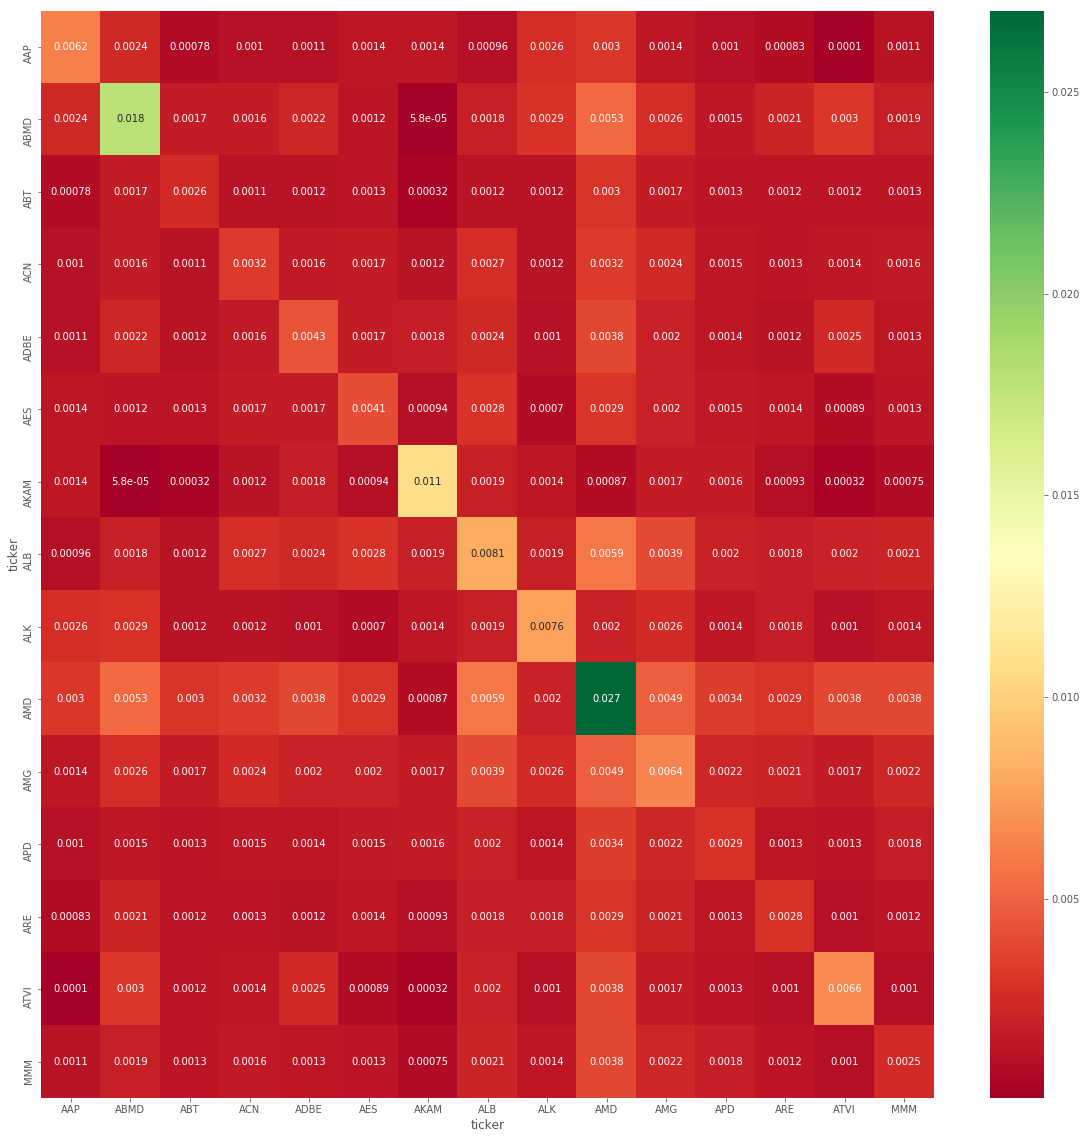

In [19]:
plt.figure(figsize=(20,20))
g=sns.heatmap(monthly_covariance ,annot=True,cmap="RdYlGn")

### Annual Expected Returns

Annual returns are computed by multipling the average monthly returns with 12.

  **<center> Annual expected returns = mean monthly returns * 12 </center>**


In [16]:
# Annual expected returns = mean monthly returns * 12
annual_returns = monthly_returns.mean() * 12
annual_returns

ticker
AAP     0.195382
ABMD    0.528269
ABT     0.158069
ACN     0.179984
ADBE    0.245445
AES     0.060620
AKAM    0.163658
ALB     0.149603
ALK     0.285455
AMD     0.262616
AMG     0.093273
APD     0.127325
ARE     0.122295
ATVI    0.222213
MMM     0.137600
dtype: float64

In [20]:
annual_covariance = monthly_covariance * 12

### Heat map for covariance of annual returns

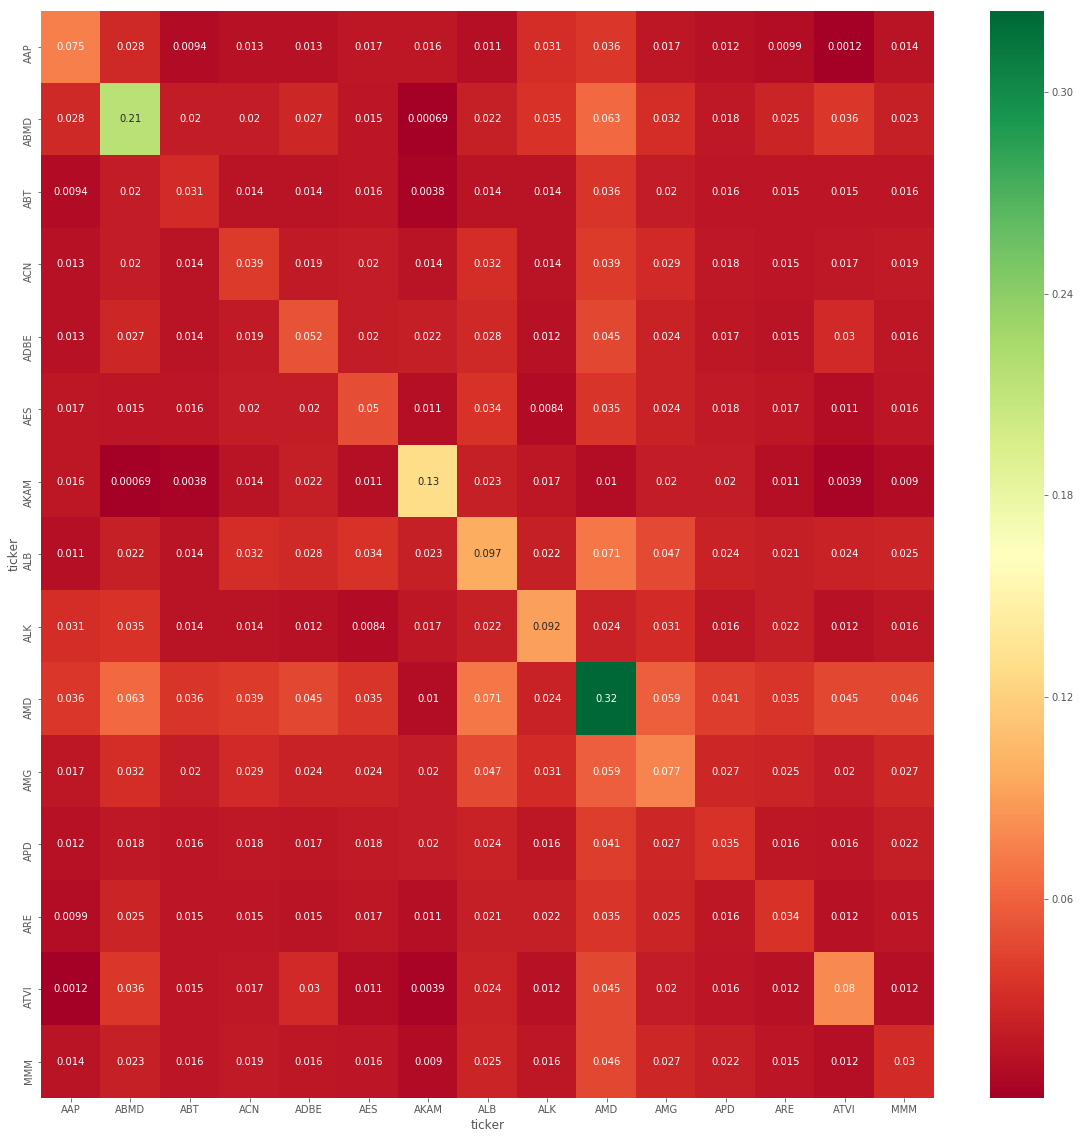

In [22]:
plt.figure(figsize=(20,20))
g=sns.heatmap(annual_covariance ,annot=True,cmap="RdYlGn")

## c) Efficient Frontier and the optimal protfolio to invest in

## Efficient Frontier

The Efficient Frontier is the set of portfolios that achieve a given return with the minimum amount of risk for that return.
It can be plotted as risk on X-axis and returns on Y-axis.
Risk is evaluated based on how the expected returns are fluctuating over a period of time i.e standred deviation.


**Efficient frontier is calculated using the following equations.**

Let’s say we have N companies and x is a vector of initial random weighs for the portfolio, μ is a vector of the average returns and σ2 is an N×N covariance matrix where:


$$ μ = \begin{pmatrix} μ_1 & μ_2 & μ_3 & ... & μ_N \end{pmatrix}$$ 


$$ x = \begin{pmatrix} w_1 \\ w_2 \\ w_3 \\ \vdots \\ w_N \end{pmatrix}$$


$$ σ2 = \begin{pmatrix}
σ_11 & σ_12 & \cdots & σ_1N \\
σ_21 & σ_22 & \cdots & σ_2N \\
\vdots & \vdots& \vdots & \ddots & \vdots \\
σ_N1 & σ_N2 & \cdots & σ_NN
\end{pmatrix}$$

**The portfolio return and variance are calculated by:**

 - _Return = np.dot(x, μ)_


 - _Variance = np.sqrt(np.dot(x.T, np.dot(σ2 , x)))_

The optimal weight vector x can be determined that satisfies either one of the conditions depending on whether the investor requires a minimum level of risk or maximum return. I am considering minimum level of risk

**Objective function:**

   - _Minimize np.sqrt(np.dot(x.T, np.dot(σ2 , x)))_

**Constraints:**

   - _Portfolio returns = Target returns_
    
   - _Sum of weights =  1_

   - _Each individual weight is greater then 0 and less than 1_

Now using the optimal weights we plot the efficient frontire with mean portfolio returns on y- axis and mean risk on x - axis.



In [729]:
# Functions

def weights_generator(num_assets):
    '''
    input : number of assets
    output: weights vector
    '''
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    return weights

def port_returns_sd(weights, annual_returns, annual_covariance):
    '''
    input: weights vector, annual returns vector, annual covariance matrix
    output: list of returns and standard deviations.
    '''
    port_returns = np.dot(weights, annual_returns)
    port_sd = np.sqrt(np.dot(weights.T, np.dot(annual_covariance, weights)))
    
    return port_returns, port_sd

def port_sd(weights, annual_returns, annual_covariance):
    '''
    input: weights vector, annual returns vector, annual covariance matrix
    output: standard deviations.
    '''
    return port_returns_sd(weights, annual_returns, annual_covariance)[1]

def port_returns(weights, annual_returns, annual_covariance):
    '''
    input: weights vector, annual returns vector, annual covariance matrix
    output: portfolio returns 
    '''
    return port_returns_sd(weights, annual_returns, annual_covariance)[0]

def minimize_sd_for_return(annual_returns, annual_covariance, targetReturn):
    '''
    input: annual returns vector, covariance matrix, target returns
    output: optimal weights 
    function: For each target return, the function minimizes the standard deviation and finds the optimal weights
    '''
    num_assets = len(annual_returns)
    args = (annual_returns, annual_covariance)
    
    constraints = ({'type': 'eq', 'fun': lambda x: port_returns(x,annual_returns, annual_covariance ) - targetReturn},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bounds = tuple((0,1) for asset in range(num_assets))
    
    return sco.minimize(port_sd, num_assets*[1./num_assets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)

def efficient_frontier(annual_returns, annual_covariance, target_Return):
    '''
    input: annual returns, annual covariance matrix, list of target returns
    output: list of optimal weights for each target return
    '''
    efficientPortfolios = []
    for returns in target_Return:
        efficientPortfolios.append(minimize_sd_for_return(annual_returns, annual_covariance, returns))

    return efficientPortfolios
    

In [114]:
#Generating target returns
target_Returns = np.linspace(0.1, 0.3, 50) 

efficientPortfolios = efficient_frontier(annual_returns, annual_covariance, target_Returns)

In [105]:
#Verifying the return value of the function efficient_frontier 
efficientPortfolios[0]

     fun: 0.19985594304326026
     jac: array([0.08126173, 0.08839886, 0.08157474, 0.10516608, 0.10016902,
       0.2183757 , 0.06175001, 0.17304979, 0.0617966 , 0.1911433 ,
       0.15389244, 0.0962167 , 0.09661813, 0.06003336, 0.08455204])
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.00000000e+00, 6.34367229e-17, 1.36864529e-16, 9.07013918e-17,
       0.00000000e+00, 7.88072378e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.27178126e-01, 0.00000000e+00,
       8.47494959e-02, 2.28329358e-17, 0.00000000e+00])

In [115]:
#Plotting the efficient frontier
iplot({'data':[go.Scatter(x = [ef['fun'] for ef in efficientPortfolios],y = target_Returns,mode = 'lines+markers',name = 'Efficient Frontier')],
'layout': go.Layout(yaxis=go.YAxis(title='Means'),
                    xaxis=go.XAxis(title='stdv'))})

## Optimal portfolios to invest in

I would invest in a portfolio that has maximum returns with minimum risk. To find this portfolio, I want to maximize the ratio of returns over risk.

**Objective function:**
Maximize returns/risk ratio. 

**Constrains:**
Sum of weights = 1


In [119]:
# min varience pf

def min_varience_pf(annual_returns, annual_covariance):
    '''
    input: annual returns vector, annual covariance matrix
    output: portfolio with minimum variance
    '''
    numAssets = len(annual_returns)
    args = (annual_returns, annual_covariance)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(port_sd, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return opts


# Portfolio I would to invest in 

def ratio_bw_returns_sd(weights, annual_returns, annual_covariance):
    '''
    input: weights, annual returns, annual covariance matrix
    output: negation of returns VS standard deviation ratio
    '''
    
    port_ret, port_sd = port_returns_sd(weights, annual_returns, annual_covariance)
    
    return -(port_ret)/ port_sd

def pf_i_would_invest(annual_returns, annual_covariance):
    '''
    input: annual returns, annual covarince matrix
    output: optmial portfolio to invest in
    function: minimizes the negation of returns VS standard deviation ratio
    '''
    numAssets = len(annual_returns)
    args = (annual_returns, annual_covariance)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple( (0,1) for asset in range(numAssets))

    opts = sco.minimize(ratio_bw_returns_sd, numAssets*[1./numAssets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    
    return opts

In [117]:
#Calculating minimum risk portfolio's weights
min_risk = min_varience_pf(annual_returns, annual_covariance)

#Calculating returns and standard deviation for the minimum risk portfolio
mr_return, mr_sd = port_returns_sd(min_risk['x'], annual_returns, annual_covariance)

print(mr_return, mr_sd)

0.15487464351948488 0.13202363594014452


In [120]:
#Calculating portfolio I would invest in
my_pf = pf_i_would_invest(annual_returns, annual_covariance)
my_return, my_sd = port_returns_sd(my_pf['x'], annual_returns, annual_covariance)

print(my_return, my_sd)

0.26919769411794175 0.17010850214296716


In [137]:
#Plotting the efficient frontier along with minimum risk portfolio along with the portfolio I would invest in. 

iplot({'data':[
    go.Scatter(
        x = [ef['fun'] for ef in efficientPortfolios],
        y = target_Returns,
        mode = 'lines+markers',
        name = 'Efficient Frontier'),
    go.Scatter(
        x = [my_sd],
        y = [my_return],
        mode = 'markers',
        marker={'color': 'red', 'symbol': 204, 'size': 10},
        name = 'Portfolio I would Invest'),
    go.Scatter(
        x = [mr_sd],
        y = [mr_return],
        mode = 'markers',
        marker={'color': 'green', 'symbol': 214, 'size': 10},
        name = 'Minimum Risk')
],
'layout': go.Layout(yaxis=go.YAxis(title='Means'),
                    xaxis=go.XAxis(title='stdv'))})

## d) Adding short sale constraints to the efficient frontier.

Efficient frontier with short sale constraints can have negative weigts. Therefore, we allow negative values for the optimization of weights. 


**Ojective function:**
- _minimize np.sqrt(np.dot(x.T, np.dot(σ2 , x)))_

**Constraints:**
- _portfolio returns = Target returns_

- _sum of weights =  1_


In [148]:
def minimize_sd_for_return_short_sale(annual_returns, annual_covariance, targetReturn):
    '''
    input: annual returns, annual convariance, target return
    output: for each target return, the function minimizes the standard deviation and finds the optimal weights
    '''
    num_assets = len(annual_returns)
    args = (annual_returns, annual_covariance)
    
    constraints = ({'type': 'eq', 'fun': lambda x: port_returns(x,annual_returns, annual_covariance ) - targetReturn},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    bounds = tuple((None, None) for asset in range(num_assets))
    
    return sco.minimize(port_sd, num_assets*[1./num_assets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)

def efficient_frontier_short_sale(annual_returns, annual_covariance, target_Return):
    '''
    input: annual returns, annual covariance, target return
    output: list of optimal weights for each target return with shoert sale
    '''
    efficientPortfolios = []
    for returns in target_Return:
        efficientPortfolios.append(minimize_sd_for_return_short_sale(annual_returns, annual_covariance, returns))

    return efficientPortfolios

In [149]:
target_Returns = np.linspace(0.1, 0.3, 50)

efficientPortfolios_short_sale = efficient_frontier_short_sale(annual_returns, annual_covariance, target_Returns)

In [150]:
iplot({'data':[
    go.Scatter(
        x = [ef['fun'] for ef in efficientPortfolios],
        y = target_Returns,
        mode = 'lines+markers',
        name = 'Efficient Frontier'),
    go.Scatter(
        x = [ef['fun'] for ef in efficientPortfolios_short_sale],
        y = target_Returns,
        mode = 'lines+markers',
        marker={'color': 'red', 'symbol': 104},
        name = 'Efficient Frontier with short sale'),
    go.Scatter(
        x = [my_sd],
        y = [my_return],
        mode = 'markers',
        marker={'color': 'red', 'symbol': 204, 'size': 10},
        name = 'Portfolio I would Invest'),
    go.Scatter(
        x = [mr_sd],
        y = [mr_return],
        mode = 'markers',
        marker={'color': 'green', 'symbol': 214, 'size': 10},
        name = 'Minimum Risk')
],
'layout': go.Layout(yaxis=go.YAxis(title='Means'),
                    xaxis=go.XAxis(title='stdv'))})

**From the above plot, it is clear that the efficient frontier with short sale constraints has lower risks for the same returns compared to the efficient frontier without short sale constraints.** 


## e) Difficulties in computing covariance for a more than 200 equities

In the above question, we worked with 15 equties for  which tha matrix dimensions were 108 rows and 15 columns (108 represents 12months * 9 years). 
For 200 equities, considering the same time period, we will have a matrix of 200 columns and 108 rows. 

When the number of column is larger than the number of rows, the sample covariance matrix is not of full rank, so its inverse will not exist. Even if the sample covariance matrix is invertible, the expected value of the inverse is a biased estimate of the theoritical inverse. 

**The following methods can be used to overcome this problem:**
- **The shrinkage method.** The shrinkage estimator is a linear combination of the sample estimator and another estimator. The latter can be the covariance matrix implied by the CAPM theory. How to determine the optimal shrinkage will be discussed.

- **Factor models.** We consider covariance matrices implied by the large dimensional factor models, either observable or latent factor models. For the latter, we discuss the principal components method and the maximum likelihood method.

- **Bayesian and empirical Bayes estimators.** These estimators are related to the shrinkage estimator. They provide alternative interpretations for the shrinkage method.

- **The method based on random matrix theory.** This method aims to attenuate the randomness of the sample covariance S using the theory of random matrices of high dimension.


# II. Linear Regression

## a) Creating the data frame

In [2]:
data = pd.read_csv('performance.csv')

In [3]:
data.head()

,ID,Date,Performance
0,1,1990-01-01,-0.025733
1,2,1990-01-01,-0.015090
2,3,1990-01-01,-0.029002
3,4,1990-01-01,-0.020256
4,5,1990-01-01,-0.015345


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33734 entries, 0 to 33733
Data columns (total 3 columns):
ID             33734 non-null int64
Date           33734 non-null object
Performance    33734 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 790.7+ KB


In [5]:
info = pd.read_csv('info.txt', sep = ' ')

In [6]:
info.head()

,ID,Name,Currency,Focus
0,1,Index,EUR,NaN
1,2,Stock AC,USD,United States
2,3,Stock AD,GBP,United Kingdom
3,4,Stock AJ,EUR,France
4,5,Stock AK,USD,United States


In [7]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 4 columns):
ID          101 non-null int64
Name        101 non-null object
Currency    101 non-null object
Focus       100 non-null object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB


In [8]:
#Performing left join between Data and Info on ID
df = data.merge(info, on = ['ID'], how = 'left')

In [9]:
df.head()

,ID,Date,Performance,Name,Currency,Focus
0,1,1990-01-01,-0.025733,Index,EUR,NaN
1,2,1990-01-01,-0.015090,Stock AC,USD,United States
2,3,1990-01-01,-0.029002,Stock AD,GBP,United Kingdom
3,4,1990-01-01,-0.020256,Stock AJ,EUR,France
4,5,1990-01-01,-0.015345,Stock AK,USD,United States


In [10]:
#Required dataframe with date, performance and Name
f_df = df[['Date', 'Performance', 'Name']]

In [11]:
f_df.head()

,Date,Performance,Name
0,1990-01-01,-0.025733,Index
1,1990-01-01,-0.015090,Stock AC
2,1990-01-01,-0.029002,Stock AD
3,1990-01-01,-0.020256,Stock AJ
4,1990-01-01,-0.015345,Stock AK


## b) Writing the data frame into an Excel file

In [12]:
# saving the data to csv
df.to_csv('data.csv')

In [13]:
# Creating seperate columns for Index and stock CZ

r_df = f_df[f_df['Name'] == 'Index'].merge(f_df[f_df['Name'] == 'Stock CZ'], on = 'Date', how = 'inner')

In [14]:
r_df.head()

,Date,Performance_x,Name_x,Performance_y,Name_y
0,1990-01-01,-0.025733,Index,-0.023821,Stock CZ
1,1990-02-01,0.090679,Index,0.066868,Stock CZ
2,1990-03-01,0.060580,Index,0.057932,Stock CZ
3,1990-04-01,0.003742,Index,0.002947,Stock CZ
4,1990-05-01,0.023790,Index,0.028535,Stock CZ


In [15]:
r_df = r_df.drop(labels=['Name_x', 'Name_y'],axis=1)
r_df = r_df.rename(columns={'Performance_x' : 'Index',
            'Performance_y' : 'Stock CZ'}, )

In [16]:
r_df.head()

,Date,Index,Stock CZ
0,1990-01-01,-0.025733,-0.023821
1,1990-02-01,0.090679,0.066868
2,1990-03-01,0.060580,0.057932
3,1990-04-01,0.003742,0.002947
4,1990-05-01,0.023790,0.028535


In [17]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## c) Regressing Stock CZ against  Index

In [18]:
X = np.array(r_df['Index']).reshape(-1, 1)
y = np.array(r_df['Stock CZ']).reshape(-1, 1)

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     4664.
Date:                Wed, 03 Jul 2019   Prob (F-statistic):          1.55e-197
Time:                        21:59:39   Log-Likelihood:                 1053.9
No. Observations:                 334   AIC:                            -2104.
Df Residuals:                     332   BIC:                            -2096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.492      0.6

- null hypothesis that the coefficient is equal to zero (no effect).
- alternate hypothosis is that is is not equal to zero (have effect).


**The coefficient for the index is 0.8069 and its p-value is 0. So, this is significantly differenct from zero. The constant term is -0.003 and its p-value is 0.623. So, this not significant and equal to zero** 



In [19]:
ypred = est2.predict(X2)
print('Mean squared error {}'. format(mean_squared_error(y, ypred)))

Mean squared error 0.000106393974950399


## d) Plotting CZ returns against fitted returns from linear regression

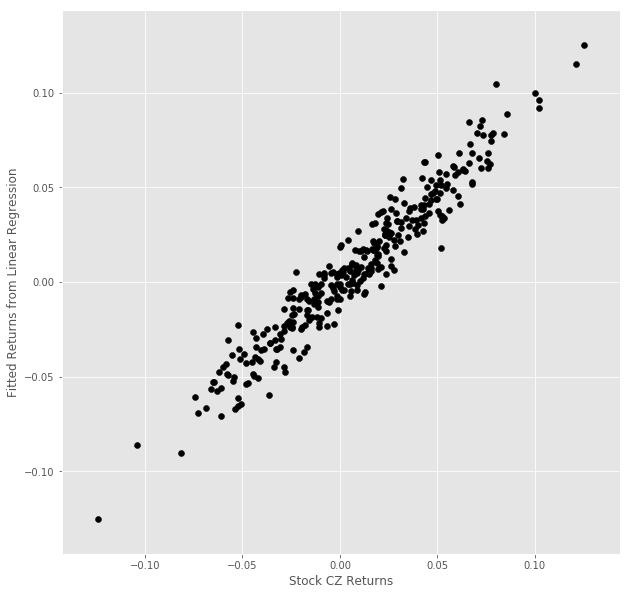

In [24]:
# Plot outputs
plt.figure(figsize=(10,10))
plt.scatter(y, ypred,  color='black')
plt.xlabel('Stock CZ Returns')
plt.ylabel('Fitted Returns from Linear Regression')
plt.show()

# III. Correlated Contribution Times

In [139]:
def cdf(x, amt, bins_fac):
    '''
    input: x - list of times when each company is purchased
           amt - commitment amount for each company
           bins_fac - lenght of the bin that converts continuous time to discrete years
    output: serirs of cummulative contributions
    '''
    df = pd.DataFrame(x, columns = ['time'])
    df['amt'] = 0.1
    df = df.sort_values(by=['time'])
    
    bins = [bins_fac*i for i in range(15)]
    labels = [i for i in range(14)]
    df['year'] = pd.cut(df['time'], bins=bins, labels=labels)
    
    df_yearly = df.groupby(['year'], as_index=False)['amt'].sum()
    df_yearly['cum_sum'] = df_yearly['amt'].cumsum()
    
    return df_yearly['cum_sum']

def sim_exp(n, amt, bin_fac):
    '''
    input: n - number of simulations to be generated
           amt - commitment amount for each company
           bins_fac - lenght of the bin that converts continuous time to discrete years 
   output: data frame with each column as a different simulation 
   '''
    df = pd.DataFrame()
    
    for i in range(n):
        x = np.random.exponential(scale=2.5, size=10)
        col_name = 'sim-' + str(i)
        df[col_name] = cdf(x, amt, bin_fac)
    
    return df

### Interpretation of lambda 

- The value of 1/lambda is referred as rate. (1/lambda = 2.5 in this case)
- The expected value of an exponentially distributed random variable X with rate parameter lambda is given by: 
         E[X] = 1/lambda
- The exponential distribution with labmda = 1/2.5 is the time between events in a Poisson point process i.e., a process in which events occur constantly and independently at a constant average rate. 


## a) Cummulative Contributions for one fund. 

In [140]:
sim_1 = sim_exp(1, 0.1, 1)

In [141]:
iplot({'data':[
    go.Scatter(
        x = sim_1.mean(axis = 1).index,
        y = sim_1.mean(axis = 1).to_list(),
        mode = 'lines+markers',
        name = 'CDF')],
'layout': go.Layout(yaxis=go.YAxis(title='Cummulative Contributions'),
                    xaxis=go.XAxis(title='Years'))})

 ## b) Average Cummulative Contribution curve of 100 funds

In [187]:
a = sim_exp(100, 0.1, 1)

In [188]:
iplot({'data':[
    go.Scatter(
        x = a.mean(axis = 1).index,
        y = a.mean(axis = 1).to_list(),
        mode = 'lines+markers',
        name = 'CDF')],
'layout': go.Layout(yaxis=go.YAxis(title='Mean'),
                    xaxis=go.XAxis(title='Years'))})

The above average cummulative contribution curve is generated using the following steps: 
- To caluclate the cummulative contribution for one fund, I used the function np.random.exponential to generate 10 time points. I aggregated all time points for each year (this parameter 'year' is considered as a bin in the cdf function defined above), and then plotted the aggregated values.
- Now, for 100 funds, 100 simulations of the above example are made and for each year I took the average and plotted average cumulative contribution curve.
-

In [146]:
def cdf(x, amt, bins_fac):
    '''
    input: x - list of times when each company is purchased
           amt - commitment amount for each company
           bins_fac - lenght of the bin that converts continuous time to discrete years
    output: serirs of cummulative contributions
    '''
    df = pd.DataFrame(x, columns = ['time'])
    df['amt'] = 0.1
    df = df.sort_values(by=['time'])
    
    bins = [bins_fac*i for i in range(15)]
    labels = [i for i in range(14)]
    df['year'] = pd.cut(df['time'], bins=bins, labels=labels)
    
    df_yearly = df.groupby(['year'], as_index=False)['amt'].sum()
    df_yearly['cum_sum'] = df_yearly['amt'].cumsum()
    
    return df_yearly['cum_sum']

def sim_dep(n, amt, bin_fac):
    '''
    input: n - number of simulations to be generated
           amt - commitment amount for each company
           bins_fac - lenght of the bin that converts continuous time to discrete years 
   output: data frame with each column as a different simulation 
   '''
    df = pd.DataFrame()
    for i in range(n):
        x = [np.random.exponential(scale=2.5, size=1)]
        for _ in range(1,10):
            if len(x) == 1:
                x.append(x[-1] + 0.6*(x[-1] - 0))
            else:
                x.append(x[-1] + 0.6*(x[-1] - x[-2]))
        col_name = 'sim-' + str(i)
        df[col_name] = cdf(x, amt, bin_fac)
    
    return df

- To generate dependent times, I used the following equation. 

\begin{equation*} x[t_n] = x[t_{n-1}] + 0.6 * (x[t_{n-1}] - x[t_{n-2}) \end{equation*}

- To ggenerate the first values, I used the np.random.exponential function to generate one point. To generate the second poin, X[tn-2] is considered as 0. All other points are generated using the above equation. 

- According to the given condition, if I find one excellent company to buy, it is more likely that I will find another company to purchase. Therefore, current contribution time is calculated by adding the previous contribution times plus 0.6 times the difference between the penultimate time and the antepenultimate time.


In [147]:
sim_1_dep = sim_dep(1, 0.1, 1)

In [148]:
iplot({'data':[
    go.Scatter(
        x = sim_1_dep.mean(axis = 1).index,
        y = sim_1_dep.mean(axis = 1).to_list(),
        mode = 'lines+markers',
        name = 'CDF')],
'layout': go.Layout(yaxis=go.YAxis(title='Cummulative Contributions'),
                    xaxis=go.XAxis(title='Years'))})

### C)

In [149]:
sim_100_dep = sim_dep(100, 0.1, 1)

In [150]:
iplot({'data':[
    go.Scatter(
        x = sim_100_dep.mean(axis = 1).index,
        y = sim_100_dep.mean(axis = 1).to_list(),
        mode = 'lines+markers',
        name = 'CDF')],
'layout': go.Layout(yaxis=go.YAxis(title='Cummulative Contributions'),
                    xaxis=go.XAxis(title='Years'))})

### Comparing the graphs for independent and dependent contribution times

For the average cummulative contribution curve with independent times, the rate of change of slope decreases over the time. 
Where as, for the average cummulative contribution curve with dependent times the rate of change of slope remains almost constant.

In [171]:
# e...

def sum_cont_yearly(x, amt, bins_fac):
    '''
    input: x - list of times when each company is purchased
           amt - commitment amount for each company
           bins_fac - lenght of the bin that converts continuous time to discrete years
    output: serirs of sum of contributions in that year
    '''    
    df = pd.DataFrame(x, columns = ['time'])
    df['amt'] = 0.1
    df = df.sort_values(by=['time'])
    
    bins = [bins_fac*i for i in range(15)]
    labels = [i for i in range(14)]
    df['year'] = pd.cut(df['time'], bins=bins, labels=labels)
    
    df_yearly = df.groupby(['year'], as_index=False)['amt'].sum()
    df_yearly['cum_sum'] = df_yearly['amt'].cumsum()
    
    return df_yearly['amt']

def sim_sum_exp(n, amt, bin_fac):
    '''
    input: n - number of simulations to be generated
           amt - commitment amount for each company
           bins_fac - lenght of the bin that converts continuous time to discrete years 
    output: data frame with each column as a different simulation 
    '''
    df = pd.DataFrame()
    for i in range(n):
        x = np.random.exponential(scale=2.5, size=10)
        col_name = 'sim-' + str(i)
        df[col_name] = sum_cont_yearly(x, amt, bin_fac)
    
    return df


In [172]:
yearly_sum_exp = sim_sum_exp(100, 0.1, 1)

In [173]:
def sim_sum_dep(n, amt, bin_fac):
    '''
    input: n - number of simulations to be generated
           amt - commitment amount for each company
           bins_fac - lenght of the bin that converts continuous time to discrete years 
    output: data frame with each column as a different simulation 
    '''
    df = pd.DataFrame()
    
    for i in range(n):
        x = [np.random.exponential(scale=2.5, size=1)]
        for _ in range(1,10):
            if len(x) == 1:
                x.append(x[-1] + 0.6*(x[-1] - 0))
            else:
                x.append(x[-1] + 0.6*(x[-1] - x[-2]))
        col_name = 'sim-' + str(i)
        df[col_name] = sum_cont_yearly(x, amt, bin_fac)
    
    return df

In [174]:
yearly_sum_dep = sim_sum_dep(100, 0.1, 1)

In [189]:
# plotting the distribution for year 1

exp = yearly_sum_exp.iloc[0].to_list()
dep = yearly_sum_dep.iloc[0].tolist()

# Group data together
hist_data = [exp, dep]

group_labels = ['Exponential', 'Dependent']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.1)

# Plot!
iplot(fig, filename='Distplot with Multiple Datasets')

print('Mean of the exp is {}'.format(np.mean(exp)))
print('sd of the exp is {}'.format(np.std(exp)))
print('Mean of the dep is {}'.format(np.mean(dep)))
print('sd of the dep is {}'.format(np.std(dep)))

Mean of the exp is 0.317
sd of the exp is 0.15235156710713546
Mean of the dep is 0.19899999999999998
sd of the dep is 0.3686448155067421


From the above graph, it is clear that for dependent times, more simulations resulted in less contribution amounts. And, for the plot with independent times, more simulations resulted in high contribution amounts. 
Therefore, the client would have to hold less cash in the case of dependent time values.